# Video Game Sales Genre & Platform Prediction
This notebook demonstrates feature selection, feature extraction, and predictive modeling to classify video game genre and platform using historical sales and ratings data.

In [2]:
!pip install xgboost


  Using cached xgboost-3.0.0-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.0-py3-none-win_amd64.whl (150.0 MB)


🎮 Genre Prediction Accuracy
XGBoost:        0.4438848920863309
Random Forest:  0.43884892086330934
Ensemble:       0.4474820143884892

📊 Genre Classification Report (Ensemble):
              precision    recall  f1-score   support

           0       0.40      0.39      0.40       329
           1       0.43      0.12      0.18        77
           2       0.45      0.70      0.54       468
           3       0.42      0.24      0.31       137
           4       0.48      0.15      0.23       196
           5       0.54      0.51      0.52       183

    accuracy                           0.45      1390
   macro avg       0.45      0.35      0.36      1390
weighted avg       0.45      0.45      0.42      1390


🕹 Platform Prediction Accuracy
XGBoost:        0.781294964028777
Random Forest:  0.7705035971223022
Ensemble:       0.7877697841726619

📊 Platform Classification Report (Ensemble):
              precision    recall  f1-score   support

           0       0.44      0.34      0.39

100%|===================| 598/600 [00:22<00:00]        

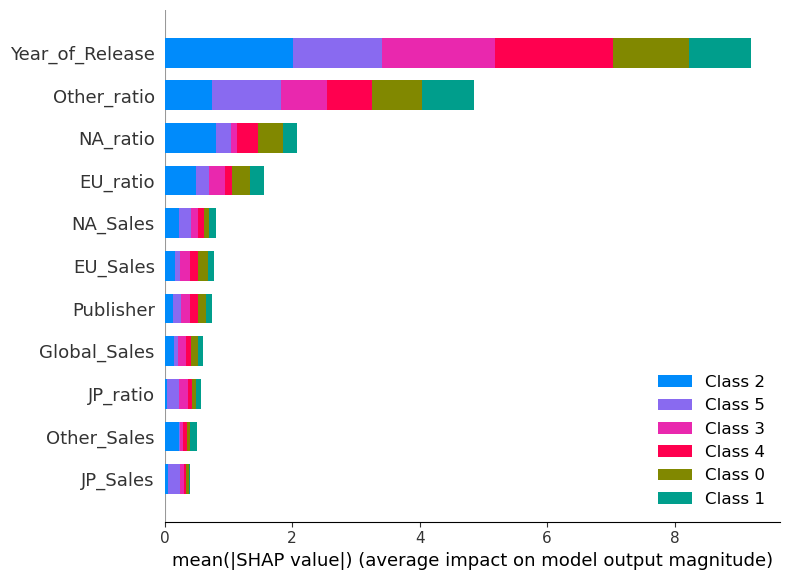

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
import shap
import warnings
warnings.filterwarnings("ignore")

# Load data
games = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')
games = games.dropna(subset=['Genre', 'Platform', 'Global_Sales'])
games = games[games['Global_Sales'] > 0]

# Simplify categories
games['Genre'] = games['Genre'].apply(lambda x: x if x in games['Genre'].value_counts().nlargest(5) else 'Other')
games['Platform'] = games['Platform'].apply(lambda x: x if x in games['Platform'].value_counts().nlargest(5) else 'Other')
games['Publisher'] = games['Publisher'].apply(lambda x: x if x in games['Publisher'].value_counts().nlargest(10) else 'Other')

# Handle year
games['Year_of_Release'] = games['Year_of_Release'].fillna(games['Year_of_Release'].mode()[0])

# Encode labels
for col in ['Genre', 'Platform', 'Publisher']:
    games[col] = LabelEncoder().fit_transform(games[col])

# Feature Engineering
games['NA_ratio'] = games['NA_Sales'] / games['Global_Sales']
games['EU_ratio'] = games['EU_Sales'] / games['Global_Sales']
games['JP_ratio'] = games['JP_Sales'] / games['Global_Sales']
games['Other_ratio'] = games['Other_Sales'] / games['Global_Sales']
games = games.replace([np.inf, -np.inf], 0).dropna()

# Features & Targets
features = ['Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales',
            'Year_of_Release', 'Publisher', 'NA_ratio', 'EU_ratio', 'JP_ratio', 'Other_ratio']
X = games[features]
y_genre = games['Genre']
y_platform = games['Platform']

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_scaled, y_genre, test_size=0.2, random_state=42)
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_scaled, y_platform, test_size=0.2, random_state=42)

# --- Base Models ---
xgb_model = xgb.XGBClassifier(n_estimators=150, max_depth=6, learning_rate=0.1,
                              use_label_encoder=False, eval_metric='mlogloss', random_state=42)
rf_model = RandomForestClassifier(n_estimators=200, max_depth=12, min_samples_split=5, random_state=42)

# Train base models (for comparison)
xgb_model.fit(X_train_g, y_train_g)
rf_model.fit(X_train_g, y_train_g)

pred_xgb_g = xgb_model.predict(X_test_g)
pred_rf_g = rf_model.predict(X_test_g)

# --- Ensemble Model (Voting) ---
ensemble_model = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('rf', rf_model)
], voting='soft')  # soft = use predicted probabilities

ensemble_model.fit(X_train_g, y_train_g)
pred_ensemble_g = ensemble_model.predict(X_test_g)

# --- Results: Genre ---
print("🎮 Genre Prediction Accuracy")
print("XGBoost:       ", accuracy_score(y_test_g, pred_xgb_g))
print("Random Forest: ", accuracy_score(y_test_g, pred_rf_g))
print("Ensemble:      ", accuracy_score(y_test_g, pred_ensemble_g))

print("\n📊 Genre Classification Report (Ensemble):")
print(classification_report(y_test_g, pred_ensemble_g))

# --- Repeat for Platform ---
xgb_model.fit(X_train_p, y_train_p)
rf_model.fit(X_train_p, y_train_p)

pred_xgb_p = xgb_model.predict(X_test_p)
pred_rf_p = rf_model.predict(X_test_p)

ensemble_model = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('rf', rf_model)
], voting='soft')
ensemble_model.fit(X_train_p, y_train_p)
pred_ensemble_p = ensemble_model.predict(X_test_p)

# --- Results: Platform ---
print("\n🕹 Platform Prediction Accuracy")
print("XGBoost:       ", accuracy_score(y_test_p, pred_xgb_p))
print("Random Forest: ", accuracy_score(y_test_p, pred_rf_p))
print("Ensemble:      ", accuracy_score(y_test_p, pred_ensemble_p))

print("\n📊 Platform Classification Report (Ensemble):")
print(classification_report(y_test_p, pred_ensemble_p))

# --- SHAP for Genre Ensemble (XGBoost only, for interpretability) ---
explainer = shap.Explainer(xgb_model, X_train_g[:100])
shap_values = explainer(X_train_g[:100])
shap.summary_plot(shap_values, X_train_g[:100], feature_names=features)